<a href="https://colab.research.google.com/github/rushilg99/BayesianInference/blob/master/ABtest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Consider the prospect of building a website and trying to find out whether or not a bigger button will improve sales.
# Assume we create 2 different websites - one is the normal website (A) and the other is the normal website with a bigger button (B)
# Maybe 2000 people are directed to each website.
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

In [2]:
# Let's generate the data first
pA = 0.2 # True probability of buying a product from site A
pB = 0.3 # True probability of buying a product from site B
websiteA = stats.bernoulli.rvs(pA, size=2000)
websiteB = stats.bernoulli.rvs(pB, size=2000)
# The model DOES NOT see these probabilities, just the data.

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [pB]
>Metropolis: [pA]
100%|██████████| 30500/30500 [00:10<00:00, 2821.11it/s]
The number of effective samples is smaller than 10% for some parameters.


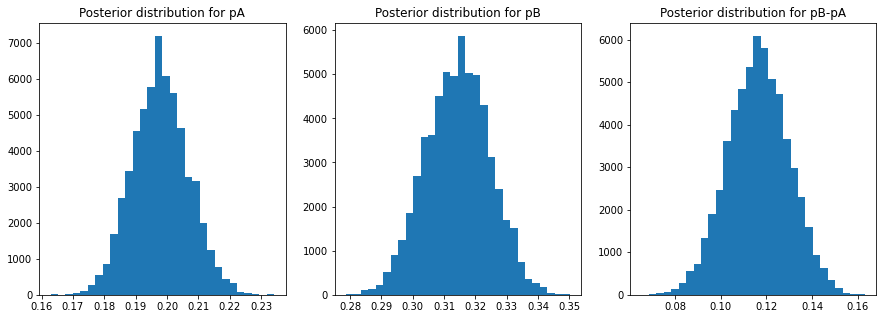

In [3]:
with pm.Model() as model:
  # We are trying to estimate pA, pB and pB - pA
  pA = pm.Uniform("pA",0,1)
  pB = pm.Uniform("pB",0,1)
  diff = pm.Deterministic("diff", pB-pA)

  obsA = pm.Bernoulli("obsA",pA,observed=websiteA)
  obsB = pm.Bernoulli("obsB",pB,observed=websiteB)

  # Monte Carlo sampling
  step = pm.Metropolis()
  trace = pm.sample(30000,step=step)

pAtrace = trace["pA"]
pBtrace = trace["pB"]
diffTrace = trace["diff"]

print("\n")
fig = plt.figure(figsize=(15,5))
plt.subplot(131)
plt.title("Posterior distribution for pA")
plt.hist(pAtrace,bins=30)
plt.subplot(132)
plt.title("Posterior distribution for pB")
plt.hist(pBtrace,bins=30)
plt.subplot(133)
plt.title("Posterior distribution for pB-pA")
plt.hist(diffTrace,bins=30)

plt.subplots_adjust(hspace=5)
plt.show()

We can see that our posterior distribution for $p_{B}-p_{A}$ is greater than zero, suggesting that our website B is better than our website A. Choose the maximum a posteriori (MAP) test (for something more formal, because I feel uncomfortable leaving the graphs as they are!).

$H_{0}: p_{B}-p_{A} > 0$     
$H_{1}: p_{B}-p_{A} \leq 0$

In [4]:
print("Probability of H_{0} given the data:", len(diffTrace[diffTrace > 0])/float(len(diffTrace)))
print("Probability of H_{1} given the data:", len(diffTrace[diffTrace <= 0])/float(len(diffTrace)))

Probability of H_{0} given the data: 1.0
Probability of H_{1} given the data: 0.0


Clearly it makes sense to accept $H_{0}$ i.e. that $p_{B}>p_{A}$. The MAP test wasn't strictly necessary given the histogram plotted for the posterior distribution for the difference between the two probabilities. A/B testing is flexible in the sense that we didn't need to show website A and website B to the same number of users. If we (for instance) directed more users to website B, we would see a wider distribution for $p_A$ and we may well have seen different posterior probabilities for $H_0$ and $H_1$.